In [1]:
import csv
import random
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

## Part1. Text classification using RNN with random word embedding
### 1. data_preprocess

In [2]:
def get_data(file, is_train):
    csv_reader = csv.reader(open(file, newline=''), delimiter='\t')
    raw_data = list(csv_reader)[1:]
    random.shuffle(raw_data)
    text = [line[2].lower().split(' ') for line in raw_data]
    if(is_train):
        label = np.array([line[3] for line in raw_data], dtype = np.int32)
        return text, label
    else:
        return text

dev_size = 1000
train_text, train_label = get_data('data/train.tsv', 1)
print("whole dataset:", len(train_text))

validate_text = train_text[0:dev_size]
validate_label = train_label[0:dev_size]
train_text = train_text[dev_size:]
train_label = train_label[dev_size:]
test_text = get_data('data/test.tsv', 0)

print("train_text length:", len(train_text)) # list of list of words
print("train_label shape:", train_label.shape) # (N,)
print("validate_text length:", len(validate_text)) # list of list of words
print("validate_label shape:", validate_label.shape) # (N,)
print("test_text length:", len(test_text)) # list of words

whole dataset: 156060
train_text length: 155060
train_label shape: (155060,)
validate_text length: 1000
validate_label shape: (1000,)
test_text length: 66292


In [3]:
def get_vocabulary(text, min_count = 0):
    # 返回的vocabulary是dictionary类
    N = len(text)
    vocabulary = {}
    frequency = {}
    for i in range(N):
        for j in range(len(text[i])):
            if(text[i][j] in frequency.keys()):
                frequency[text[i][j]] += 1
            else:
                frequency[text[i][j]] = 1

    # check frequency
    count = 2
    vocabulary["<pad>"] = 0
    vocabulary["<unknown>"] = 1
    for key, value in frequency.items():
        if(value >= min_count):
            vocabulary[key] = count
            count += 1
    return vocabulary

train_voca = get_vocabulary(train_text)
print(len(train_voca))

16534


### 2. Hyperparameter

In [23]:
is_shuffle = True
batch_size = 32
embedding_size = 100
hidden_size = 64
load_address = None
num_kernel = 32

use_cuda = torch.cuda.is_available()
print("use_cuda: ", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

use_cuda:  True


### 3. Capsulate data

In [5]:
class dataset(Dataset):
    def __init__(self, vocabulary, text, label = None):
    # text: [[words]] of length N
    # label: numpy array [N,]
        self.encoded_data = []
        for i, sentence in enumerate(text):
            word_index = []
            for word in sentence:
                if word in vocabulary.keys():
                    word_index.append(vocabulary[word])
                else:# unknown word
                    word_index.append(1)
            if label is None:
                target = -1
            else:
                target = label[i]
            self.encoded_data.append((word_index, len(word_index), target)) # tuple of (list, scalar, scalar)
    
    def __len__(self):
        return len(self.encoded_data)
    
    def __getitem__(self, index):
        return torch.LongTensor(self.encoded_data[index][0]), self.encoded_data[index][1], self.encoded_data[index][2]

def collate_fn(batch):
    batch = sorted(batch, key=lambda x: -x[1]) # 降序排序
    sentences, lengths, labels = zip(*batch) # 配对
    padded_sentences = pad_sequence(list(sentences), batch_first = True)
    return padded_sentences.to(device), torch.LongTensor(lengths).to(device), torch.LongTensor(labels).to(device)

In [7]:
train_dataset = dataset(train_voca, train_text, train_label)
train_dataloader = DataLoader(train_dataset,         
                              batch_size = batch_size,
                              collate_fn = collate_fn,
                              shuffle = is_shuffle) 

validate_dataset = dataset(train_voca, validate_text, validate_label)
validate_dataloader = DataLoader(validate_dataset,         
                              batch_size = batch_size,
                              collate_fn = collate_fn,
                              shuffle = False) 

test_dataset = dataset(train_voca, test_text)
test_dataloader = DataLoader(test_dataset,         
                              batch_size = batch_size, 
                              collate_fn = collate_fn,
                              shuffle=False) 

### 4. Build CNN model

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.embedding = nn.Embedding(len(train_voca), embedding_size)# nn.Embedding用的是N(0,1)的随机初始化
        self.LSTM = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p = 0.5)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (3, embedding_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (4, embedding_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = num_kernel, kernel_size = (5, embedding_size)),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d(1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(num_kernel * 3, 5)
        )

    def forward(self, x, lengths):
        N = x.shape[0]
        h0 = Variable(torch.zeros(1, N, hidden_size)).to(device)
        c0 = Variable(torch.zeros(1, N, hidden_size)).to(device)
        x = self.embedding(x)
        x = x.view(N, 1, x.shape[1], x.shape[2])
        conv1 = self.conv1(x).view((N, -1))
        conv2 = self.conv2(x).view((N, -1))
        conv3 = self.conv3(x).view((N, -1))
        x = torch.cat((conv1, conv2, conv3), dim = 1)
        x = self.dropout(x)
        score = self.classifier(x)
        return score
    
model = CNN()
model = model.to(device)
if(load_address is not None):
    model = torch.load(load_address)

### 5. Train Model

In [46]:
def predict(model, dataloader):
    model.eval()
    num_correct = torch.tensor(0.0)
    num_sample = torch.tensor(0.0)
    for index,(x, lengths, y) in enumerate(dataloader):
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1)
        num_correct += torch.sum(y_predict == y)
        num_sample += x.shape[0]
    return 1.0 * num_correct / num_sample

In [47]:
optimizer = optim.SGD(model.parameters(), lr = 0.05, momentum = 0.9)

In [48]:
def train(model, dataloader, optimizer, num_epoch = 30):
    model.train()
    loss_history = []
    for i in range(num_epoch):
        losses = 0
        for index,(x, lengths, y) in enumerate(dataloader):
            optimizer.zero_grad()
            score = model(x, lengths)
            loss_fn = nn.CrossEntropyLoss().to(device)
            loss = loss_fn(score, y)
            loss.backward()
            losses += loss
            optimizer.step()
        loss_history.append(losses)
        print("Epoch: {0}, loss: {1}, accu: {2}".format(i, losses, predict(model, validate_dataloader)))
        if((i + 1) % 50 == 0):
            torch.save(model, "CNN random embedding_batch {0}_embedding {1}_epoch {2}".format(batch_size, embedding_size, i + 1))
    return loss_history

loss_history = train(model, train_dataloader, optimizer, num_epoch = 3)

Epoch: 0, loss: 9122.6630859375, accu: 0.4909999966621399
Epoch: 1, loss: 6249.5791015625, accu: 0.4950000047683716
Epoch: 2, loss: 6144.0234375, accu: 0.49900001287460327


### 6. Get Result

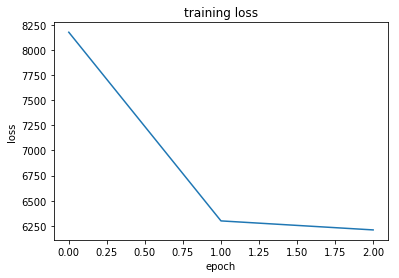

In [35]:
def plot(plt):
    plt.title("training loss")
    plt.xlabel("epoch")
    plt.ylabel('loss')
    plt.plot(range(len(loss_history)), loss_history)
    return plt

plt.figure(0)
plot(plt)
plt.show()

In [168]:
def get_answer(model, dataloader):
    answer = []
    for index,(x,lengths, y) in enumerate(dataloader):
        score = model(x, lengths)
        y_predict = torch.argmax(score, dim = 1).cpu().numpy()
        answer += list(y_predict)
    index = [a + 156061 for a in range(len(answer))]
    dataframe = pd.DataFrame({'PhraseId':index, 'Sentiment':answer})
    dataframe.to_csv("answer_RNN.csv",index=False,sep=',')
    return answer

answer = get_answer(model, test_dataloader)